# PRÁCTICA FINAL NLP
## DETECCIÓN DE SPAM

![ChessUrl](https://miro.medium.com/max/1912/1*fTPhu7PqgIbnngbWG5zFWA.gif "chess")

## Para ejecutar la práctica solo es necesario ejecutar las diferentes celdas, ya que dentro de la carpeta están los dos datasets necesarios. No debería tardar mucho, aunque los modelos de redes neuronales tardan más en ejecutarse que el de Naive Bayes.

### CARGA DE LIBRERÍAS

In [1]:
# !pip install keras
# !pip install tensorflow

In [2]:
## Se importan todas las librerías necesarias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# Para el preprocesamiento de los textos
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Preprocesamiento de las variables
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# Separación train_test
from sklearn.model_selection import train_test_split

# Modelo de Naive-Bayes
from sklearn.naive_bayes import MultinomialNB

# Modelo de deep learning
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional, Flatten, BatchNormalization
from sklearn.manifold import TSNE
from keras.optimizers import RMSprop

# Métricas
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

## ESTUDIO PREVIO DEL DATASET

In [3]:
# Se carga el dataset de los SMS 
mensajes = pd.read_csv ("spam.csv", engine='python')

In [4]:
# Se eliminan las columnas vacías 
mensajes.drop(columns = ['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace = True)
mensajes.rename(columns = {"v1" : "label", "v2" : "message"}, inplace = True)

### ESTUDIO PREVIO DE LOS PATRONES DE LOS MENSAJES DE HAM Y SPAM

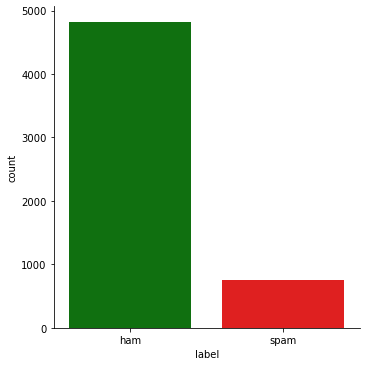

In [5]:
# Representación para estudiar cuántos datos del dataset son spam y cuántos son ham
sns.catplot(data=mensajes, x="label", kind = "count", palette=sns.color_palette(['green', 'red']))

*Se observa que hay más datos de ham que de spam (es decir los datos están desbalanceados). Sin embargo, la diferencia (85%-15%) no es suficientemente grande como para que sea necesario utilizar algoritmos de balanceo como el SMOTE. El siguiente paso es realizar un análisis de las diferencias entre los mensajes de spam y ham. Para ello, se calculan una serie de valores.*

In [6]:
# Número de palabras del mensaje
mensajes["num_palabras"] = mensajes["message"].apply(lambda s: len(re.findall(r'\w+', s)))

# Longitud del mensaje
mensajes["longitud_mensaje"] = mensajes["message"].apply(len)

# Palabras en mayúsculas
mensajes["num_mayusculas"] = mensajes["message"].apply(lambda s: sum(1 for c in s if c.isupper())) 

# Palabras mayúsculas de dos carácteres 
mensajes["num_iniciales_mayusculas"] = mensajes["message"].apply(lambda s: len(re.findall(r"\b[A-Z][A-Z]+\b", s)))

# Número de mensajes que contengan las palabras free o win
mensajes["num_free_or_win"] = mensajes["message"].apply(lambda s: int("free" in s.lower() or "win" in s.lower()))

In [7]:
mensajes

,label,message,num_palabras,longitud_mensaje,num_mayusculas,num_iniciales_mayusculas,num_free_or_win
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,3,0,0
1,ham,Ok lar... Joking wif u oni...,6,29,2,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,33,155,10,2,1
3,ham,U dun say so early hor... U c already then say...,11,49,2,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",14,61,2,0,0
...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,33,161,9,1,0
5568,ham,Will Ì_ b going to esplanade fr home?,8,37,2,0,0
5569,ham,"Pity, * was in mood for that. So...any other s...",10,57,2,0,0
5570,ham,The guy did some bitching but I acted like i'd...,27,125,2,0,1


In [8]:
# Se ordenan los mensajes por la longitud y se obtienen los 5 primeros. 
mensajes.sort_values(by = 'longitud_mensaje',ascending = False).head(5)

,label,message,num_palabras,longitud_mensaje,num_mayusculas,num_iniciales_mayusculas,num_free_or_win
1084,ham,For me the love should start with attraction.i...,190,910,12,0,0
1862,ham,The last thing i ever wanted to do was hurt yo...,173,790,14,1,0
2433,ham,Indians r poor but India is not a poor country...,115,632,25,2,1
1578,ham,How to Make a girl Happy? It's not at all diff...,91,611,28,0,0
2847,ham,Sad story of a Man - Last week was my b'day. M...,119,588,53,4,0


*Se observa que el SMS más largo tiene 910 caracteres. Se accede al SMS para ver su contenido.*

In [9]:
## SMS más largo del dataset
mensajes[mensajes['longitud_mensaje'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [10]:
# Calcular la longitud media del mensaje en función del tipo de mensaje
labels = mensajes.groupby('label').mean()
labels

,num_palabras,longitud_mensaje,num_mayusculas,num_iniciales_mayusculas,num_free_or_win
label,,,,,
ham,14.677098,71.023627,4.035233,0.389845,0.026943
spam,25.821954,138.866131,15.441767,2.032129,0.369478


*Se observa claramente que los mensajes que son spam tienden a tener una longitud mayor que los de ham. Esto nos indica que la longitud del mensaje es una característica (feature) importante a la hora de predecir si un mensaje es ham o spam.*

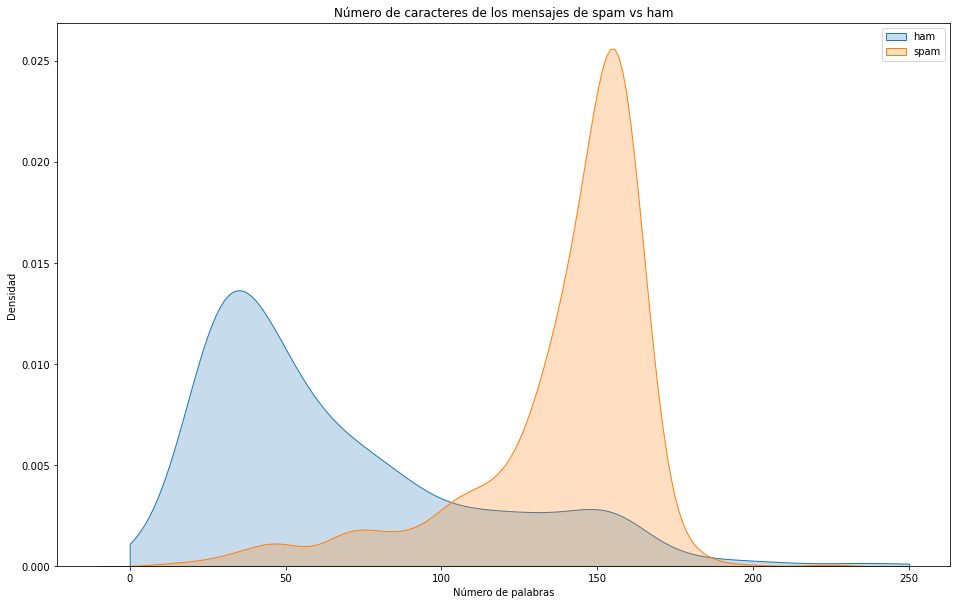

In [11]:
# Se representan los mensajes de ham y spam para comprobar cómo es la distribución en cada uno por longitud
# Se limita a 250 para dejar fuera los outliers (como el mensaje SMS de 910 caracteres)
_,ax = plt.subplots(figsize=(16,10))
sns.kdeplot(mensajes.loc[mensajes.label == "ham", "longitud_mensaje"], shade=True, label="ham", clip=(0, 250), palette="Green") 
sns.kdeplot(mensajes.loc[mensajes.label == "spam", "longitud_mensaje"], shade=True, label="spam",palette = 'Reds')
ax.set(xlabel = "Número de palabras", ylabel = "Densidad",title = "Número de caracteres de los mensajes de spam vs ham")
plt.legend()
plt.show()

*Esta representación confirma que efectivamente los mensajes de spam suelen tener un mayor número de palabras y están localizados aproximadamente en 150 caracteres la mayoría.*

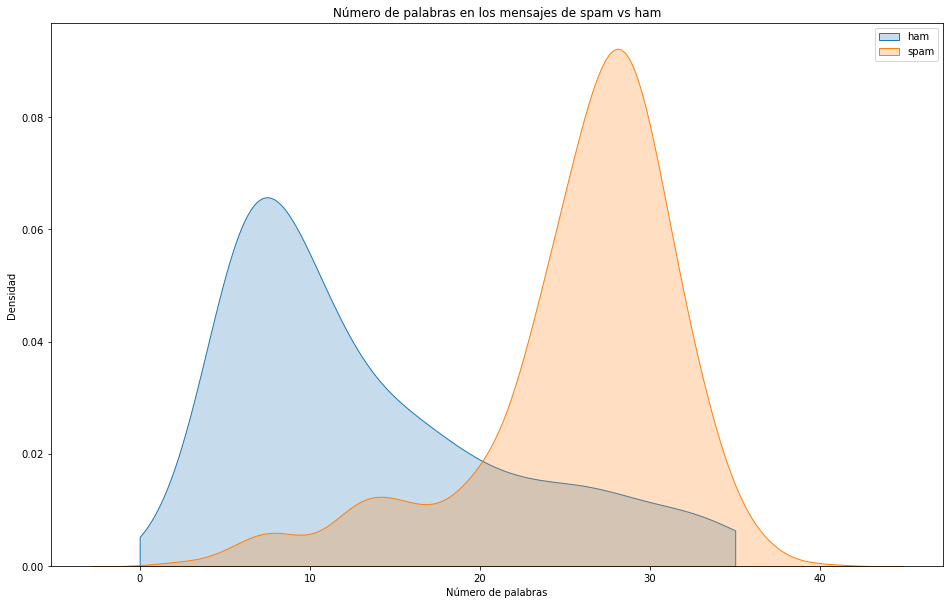

In [12]:
# Se representan los mensajes de ham y spam para comprobar cómo es la distribución en cada uno por longitud
# Se limita a 35 para dejar fuera los outliers 
_,ax = plt.subplots(figsize=(16,10))
sns.kdeplot(mensajes.loc[mensajes.label == "ham", "num_palabras"], shade=True, label="ham", clip=(0, 35), palette="Green") 
sns.kdeplot(mensajes.loc[mensajes.label == "spam", "num_palabras"], shade=True, label="spam",palette = 'Reds')
ax.set(xlabel = "Número de palabras", ylabel = "Densidad",title = "Número de palabras en los mensajes de spam vs ham")
plt.legend()
plt.show()

*De nuevo se observa que los mensajes de spam tienen generalmente mayor número de palabras, por lo que esta variable es interesante para incluirla en el modelo.*

In [13]:
# ham y spam mensajes
mensajes_ham = mensajes[mensajes.label =='ham']
mensajes_spam = mensajes[mensajes.label=='spam']

In [14]:
# Texto seguido de los mensajes de ham y de spam para hacer luego la representación con la nube de palabras
texto_ham = " ".join(mensajes_ham.message.to_numpy().tolist())
texto_spam = " ".join(mensajes_spam.message.to_numpy().tolist())

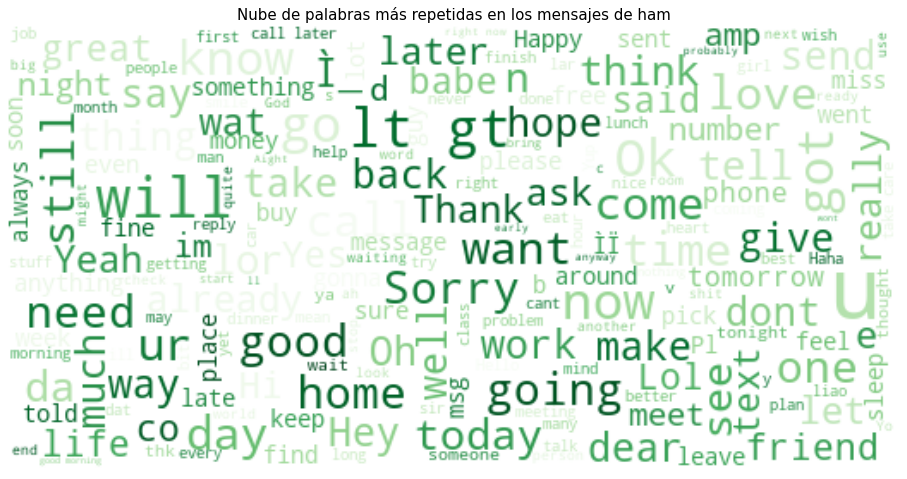

In [15]:
# Nube de palabras para los mensajes de ham
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="white", colormap='Greens').generate(texto_ham)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras más repetidas en los mensajes de ham", fontsize = 15)
plt.show()

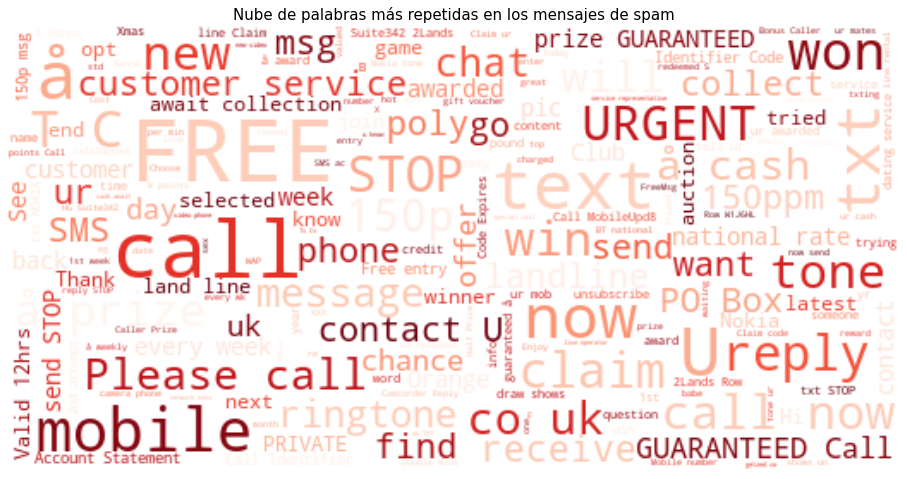

In [16]:
# Nube de palabras para los mensajes de spam
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="white", colormap='Reds').generate(texto_spam)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') 
plt.title("Nube de palabras más repetidas en los mensajes de spam", fontsize = 15)
plt.show()

### OPCIÓN 1: DETECCIÓN DE SPAM CON  MULTINOMIAL NAIVE BAYES

In [17]:
# Se pasan todas las letras a minúsculas y se convierten los mensajes en tokens
tokenized_messages = mensajes['message'].str.lower().apply(word_tokenize)

In [18]:
# Función para eliminar los caracteres que no son alfanuméricos  
def alpha(tokens):
    alpha = []
    for token in tokens:
        if str.isalpha(token) or token in ['n\'t','won\'t']:
            if token=='n\'t':
                alpha.append('not')
                continue
            elif token == 'won\'t':
                alpha.append('wont')
                continue
            alpha.append(token)
    return alpha

tokenized_messages = tokenized_messages.apply(alpha)

In [19]:
# Función para eliminar las stopwords
def remove_stop_words(tokens):
    no_stop = []
    for token in tokens:
        if token not in stopwords.words('english'):
            no_stop.append(token)
    return no_stop

tokenized_messages = tokenized_messages.apply(remove_stop_words)

In [20]:
# Función para lematizar los tokens
def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized = []
    
    for token in tokens:
        lemmatized.append(lemmatizer.lemmatize(token))
    return " ".join(lemmatized)
tokenized_messages = tokenized_messages.apply(lemmatize)

In [21]:
# Se sustituyen los nuevos mensajes en el dataframe
mensajes['message'] = tokenized_messages

In [22]:
# Se seleccionan los features y la variable objetivo (esta se sustituye por 0  o 1 si es ham o spam respectivamente)
X = mensajes['message']
Y = mensajes['label'].replace({'ham':0,'spam':1})

In [23]:
# Se divide el dataset en train y test (80% - 20%)
X_train, X_test, y_train, y_test1 = train_test_split(X, Y, test_size=0.2, random_state=34)

*El proceso de vectorización consiste en convertir una serie de textos en vectores numéricos*

In [24]:
# Se inicializa el CountVectorizer
vect = CountVectorizer()

# El vectorizer aprende el vocabulario del x_train
vect.fit(X_train)

# Transforma el train dataset en una dtm (document-term matrix) utilizando el vocabulario aprendido
x_train = vect.transform(X_train) 

# Combina fit y transform
x_train = vect.fit_transform(X_train) 

# Transforma el test dataset en una dtm (document-term matrix) utilizando el vocabulario aprendido
x_test = vect.transform(X_test) 

*Se utilizan entonces la matrices Tfidf, donde TF hace referencia al número de veces que aparece un término e IDF (Inverse-Document Frequency) mide cómo de importante es. Aquellas palabras que aparezcan mucho tendrán menos importancia que aquellas que aparezcan menos.*

In [25]:
# Se inicializa el modelo
tfidf_transformer = TfidfTransformer()

# Se entrena con el x_train 
tfidf_transformer.fit(x_train)

# Se transforma el x_train
tfidf_transformer.transform(x_train)

<4457x5879 sparse matrix of type '<class 'numpy.float64'>'
	with 33872 stored elements in Compressed Sparse Row format>

*Finalmente, se utiliza el modelo de clasificación Multinomial Naive Bayes porque trabaja muy bien con features que son discretas (como el número de veces que aparece una palabra)*

In [26]:
# Se inicia el clasificador de Naive-Bayes
nb = MultinomialNB()

# Se entrena el modelo
nb.fit(x_train, y_train)

# Se calculan las predicciones (van a servir después para las métricas)
preds_nb = nb.predict(x_test)

### OPCIÓN 2: DETECCIÓN DE SPAM CON REDES NEURONALES RECURRENTES - LSTM

<img src="https://i.morioh.com/200509/c29a077f.jpg" width="400" height="400" />

In [27]:
# Darle valor numérico a los mensajes ham (0) y spam (1)
mensajes['tipo_mensaje']= mensajes['label'].map({'ham': 0, 'spam': 1})
mensajes_label = mensajes['tipo_mensaje'].values

# Dividir el dataset en train y test
train_mensajes, test_mensajes, train_labels, test_labels = train_test_split(mensajes['message'], mensajes_label, test_size=0.2, random_state=434)

Se definen los hiperparámetros necesarios para el preprocesamiento del texto:
- Máxima longitud del mensaje  
- Tipo de padding : post (se añaden 0 al final de la frase para igualar la máxima longitud)
- Tipo de truncamiento : post (se trunca el final de la frase)

In [28]:
# Se definen los hiperparámetros para preprocesar el texto
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 1000

In [29]:
# Se actualiza el vocabulario interno en base a una serie de textos.
# Se asigna un índice a cada palabra en función de su frecuencia (el 0 se reserva para el padding) 
# OOV - out of vocabulary
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_mensajes)

In [30]:
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'u': 2,
 'call': 3,
 'get': 4,
 'ur': 5,
 'go': 6,
 'gt': 7,
 'lt': 8,
 'free': 9,
 'know': 10,
 'good': 11,
 'got': 12,
 'ok': 13,
 'like': 14,
 'come': 15,
 'day': 16,
 'time': 17,
 'text': 18,
 'want': 19,
 'love': 20,
 'send': 21,
 'one': 22,
 'r': 23,
 'need': 24,
 'today': 25,
 'lor': 26,
 'txt': 27,
 'reply': 28,
 'c': 29,
 'still': 30,
 'sorry': 31,
 'going': 32,
 'stop': 33,
 'mobile': 34,
 'home': 35,
 'back': 36,
 'da': 37,
 'take': 38,
 'think': 39,
 'phone': 40,
 'n': 41,
 'tell': 42,
 'see': 43,
 'dont': 44,
 'later': 45,
 'hi': 46,
 'new': 47,
 'week': 48,
 'please': 49,
 'make': 50,
 'pls': 51,
 'say': 52,
 'well': 53,
 'claim': 54,
 'dear': 55,
 'night': 56,
 'number': 57,
 'wat': 58,
 'thing': 59,
 'happy': 60,
 'much': 61,
 'great': 62,
 'oh': 63,
 'work': 64,
 'message': 65,
 'friend': 66,
 'hope': 67,
 'na': 68,
 'msg': 69,
 'k': 70,
 'hey': 71,
 'yes': 72,
 'right': 73,
 'give': 74,
 'let': 75,
 'prize': 76,
 'way': 77,
 'wan': 78,
 'ask': 79,
 'tomo

In [31]:
# Convertir cada texto en una secuencia de integers (en función del word_index) y hacer padding (en train y test)
training_sequences = tokenizer.texts_to_sequences(train_mensajes)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_mensajes)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,padding = padding_type, truncating = trunc_type)

In [32]:
# Tamaño del tensor de train
print('Tamaño del tensor de train: ', training_padded.shape)
print('Tamaño del tensor de test: ', testing_padded.shape)

Tamaño del tensor de train:  (4457, 50)
Tamaño del tensor de test:  (1115, 50)


In [33]:
# Longitud dos primeros mensajes antes de hacer padding
print(len(training_sequences[0]), len(training_sequences[1]))

# Longitud dos primeros mensajes después de hacer padding
print(len(training_padded[0]), len(training_padded[1]))

9 15
50 50


In [34]:
# Parámetros de la red neuronal
vocab_size = 1000 
embeding_dim = 16
drop_value = 0.2 
n_dense = 24

In [35]:
# Arquitectura modelo denso (la capa embedding es 2D , para pasar a una capa dense hay que pasar a 1D - Flatten)
# El output de la embedding layer van a ser 50 vectores de dimensión 16
# En la siguiente capa hay que pasarlo a un único vector de 50x16
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [36]:
# Descripción de las capas del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                19224     
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 35,249
Trainable params: 35,249
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Se compila el modelo con la función de pérdida 'binary_crossentropy' y el algoritmo de optimización 'adam'
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
# Se entrena el modelo. Se añade el parámetro early_stop para parar el modelo cuando el error empieza a aumentar (se da una paciencia de 3 iteraciones)
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
140/140 - 2s - loss: 0.3257 - accuracy: 0.8672 - val_loss: 0.1848 - val_accuracy: 0.9372
Epoch 2/30
140/140 - 0s - loss: 0.1186 - accuracy: 0.9659 - val_loss: 0.0977 - val_accuracy: 0.9659
Epoch 3/30
140/140 - 0s - loss: 0.0512 - accuracy: 0.9859 - val_loss: 0.0788 - val_accuracy: 0.9767
Epoch 4/30
140/140 - 0s - loss: 0.0345 - accuracy: 0.9908 - val_loss: 0.0752 - val_accuracy: 0.9803
Epoch 5/30
140/140 - 0s - loss: 0.0237 - accuracy: 0.9946 - val_loss: 0.0796 - val_accuracy: 0.9785
Epoch 6/30
140/140 - 0s - loss: 0.0177 - accuracy: 0.9960 - val_loss: 0.0752 - val_accuracy: 0.9785
Epoch 7/30
140/140 - 0s - loss: 0.0135 - accuracy: 0.9973 - val_loss: 0.0764 - val_accuracy: 0.9812
Epoch 8/30
140/140 - 0s - loss: 0.0103 - accuracy: 0.9980 - val_loss: 0.0799 - val_accuracy: 0.9812
Epoch 9/30
140/140 - 0s - loss: 0.0077 - accuracy: 0.9980 - val_loss: 0.0852 - val_accuracy: 0.9803


In [39]:
# Se evalúa el modelo para el 
model.evaluate(testing_padded, test_labels)

35/35 [==============================] - 0s 792us/step - loss: 0.0852 - accuracy: 0.9803


[0.08524762094020844, 0.9802690744400024]

In [40]:
# Se realiza la predicción del valor del label (va a dar una probabilidad de que sea spam , si es mayor de 0.5 se considera spam)
y_predict_lstm = [1 if o>0.5 else 0 for o in model.predict(testing_padded)]

### OPCIÓN 3: DETECCIÓN DE SPAM USANDO BERT Y REDES NEURONALES

*Previamente sería necesario cargar el corpus preentrenador con texto de BERT y entrenarlo con los SMS del dataset.Esto se realiza con PyTorch. Sin embargo, para este dataset ya existe un csv que incluye los mensajes encodeados con el embedding de BERT, por lo que se va a utilizar directamente. Igualmente, dejo comentado a continuación el código que se necesitaría.*

In [41]:
# # Se carga el modelo preentrenado
# tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# model = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")
# # Se aplica el corpus preentrenado a los mensajes del dataset
# tokenized = df["message"].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
# # Se rellena con 0 los SMS para que tengan el mismo tamaño
# padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
# # Se eliminan los 1 y 0 para que BERT los ignore al hacer el embedding
# attention_mask = np.where(padded != 0, 1, 0)
# # Se crea un tensor en pytorch para los mensajes después del padding
# input_ids = torch.tensor(padded)  
# # Se crea un tensor en pytorch para la attention matrix
# attention_mask = torch.tensor(attention_mask) 
# # Se envía el input a BERT par aobtener los embeddings de clasificación para los mensajes
# with torch.no_grad():
#     encoder_hidden_state = model(input_ids, attention_mask=attention_mask)

In [42]:
# Se carga el dataset de los SMS con el encode hecho por BERT para este dataset
spam_bert = pd.read_csv("spam_encoded.csv")
# Se añaden las columnas necesarias para hacer feature engineering (las que se había observado que influían)
spam_bert["num_palabras"] = spam_bert["original_message"].apply(lambda s: len(re.findall(r'\w+', s)))
spam_bert["longitud_mensaje"] = spam_bert["original_message"].apply(len)
spam_bert["num_mayusculas"] = spam_bert["original_message"].apply(lambda s: sum(1 for c in s if c.isupper())) 
spam_bert["num_iniciales_mayusculas"] = spam_bert["original_message"].apply(lambda s: len(re.findall(r"\b[A-Z][A-Z]+\b", s)))
spam_bert["num_free/win"] = spam_bert["original_message"].apply(lambda s: int("free" in s.lower() or "win" in s.lower()))
spam_bert.head()

,spam,original_message,0,1,2,3,4,5,6,7,...,763,764,765,766,767,num_palabras,longitud_mensaje,num_mayusculas,num_iniciales_mayusculas,num_free/win
0,0,"Go until jurong point, crazy.. Available only ...",-0.142966,-0.225385,0.268059,0.065721,-0.100783,-0.198441,0.390656,0.337182,...,-0.056947,-0.025428,-0.057884,0.165974,0.302198,20,111,3,0,0
1,0,Ok lar... Joking wif u oni...,-0.244984,-0.052506,0.137510,-0.623836,-0.311277,0.074931,0.652979,0.200019,...,-0.138928,0.041252,-0.045966,0.087562,0.546937,6,29,2,0,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,-0.389005,-0.030240,0.203487,-0.166000,0.020918,-0.139901,0.331638,0.095457,...,-0.084802,-0.366647,-0.106075,0.096242,0.567941,33,155,10,2,1
3,0,U dun say so early hor... U c already then say...,-0.090251,0.151952,0.069052,-0.610341,-0.220990,0.013123,0.301812,0.334780,...,-0.085699,-0.226141,-0.002507,0.255287,0.496604,11,49,2,0,0
4,0,"Nah I don't think he goes to usf, he lives aro...",0.056018,0.251125,-0.092620,-0.307521,-0.365732,-0.075228,0.414467,0.388034,...,0.016842,-0.103515,-0.076240,0.479977,0.274191,14,61,2,0,0


In [43]:
# Se inicia el StandardScaler
scaler = StandardScaler()
# Solo se estandarizan las columnas que no tienen datos binarios (como la columna llamada label o la del mensaje).
# También se elimina la columna que indica el número de veces que contiene free o win.
features_to_scale = spam_bert.drop(["spam", "original_message", "num_free/win"], axis=1)

# Se crea un nuevo dataframe con las variables escaladas
scaled_features = pd.DataFrame(scaler.fit_transform(features_to_scale))
scaled_features.rename(
    {768: "num_palabras", 769:"longitud_mensaje", 770: "num_mayusculas", 771: "num_iniciales_mayusculas"},
    axis=1,
    inplace=True)

# Se crea el dataset scaled_df para incluir todas las variables estandarizadas antes de que entren al modelo
scaled_df = spam_bert.copy()
scaled_df.update(scaled_features)

In [44]:
# Se define la variable objetivo (columna spam) y las features (se elimina el mensaje y la variable objetivo)
X = scaled_df.drop(["spam", "original_message"], axis=1)
y = scaled_df["spam"]

# Se realiza la separación en train- test
X_train, X_test, y_train, y_test2 = train_test_split(X, y, stratify=y,test_size=0.2, random_state=42)

In [45]:
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_train)

In [46]:
def representacion_componentes(data, labels=y_train, rename=False):
    df = pd.DataFrame(data)
    df["spam"] = labels.to_numpy()
    if rename:
        df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True) 
    return df
spam_bert_componentes = representacion_componentes(X_embedded, rename=True)

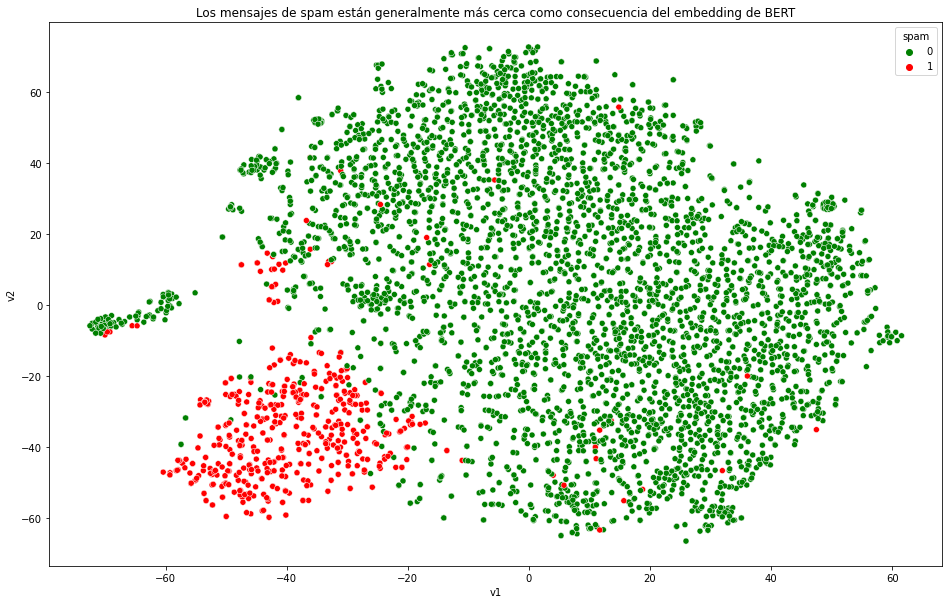

In [47]:
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", hue="spam", data=spam_bert_componentes, palette=['green','red'])
ax.set(title = "Los mensajes de spam están generalmente más cerca como consecuencia del embedding de BERT")
plt.show()

*Se observa claramente que utilizando las features adicionales correspondientes a las BERT embeddings, se obtiene un training set donde los mensajes de spam están bastante cerca entre ellos con algún outlier entre los mensajes de ham.*

In [48]:
# Se inicializa el modelo
model = Sequential()

# Se añaden las diferentes capas (es importante que la última sea densa ya que es la salida y la función sigmoidal 
# ya que estamos en un problema de clasificación binario)
# Se define el input shape (el tamaño de la matriz X)

model.add(Dense(1000, input_shape=(773,), activation="relu"))
model.add(BatchNormalization(axis=-1))

model.add(Dense(256, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Dense(256, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))

model.add(Dense(128, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Dense(10, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

# Capa de salida
model.add(Dense(1, activation="sigmoid"))

In [49]:
# Se definen los hiperparámetros del modelo
epochs = 30
bs = 64
init = 0.001
opt = RMSprop(lr = init)

# Se compila el modelo
model.compile(optimizer=opt , loss="binary_crossentropy", metrics=["accuracy"])

# Reducción de la learning rate para que vaya más rápido
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

# Se entrena el modelo
model.fit(X_train, y_train, validation_split=0.2, batch_size=bs, epochs=epochs, callbacks=[learning_rate_reduction])

Epoch 1/30
56/56 [==============================] - 3s 22ms/step - loss: 0.5308 - accuracy: 0.7578 - val_loss: 0.2694 - val_accuracy: 0.9619
Epoch 2/30
56/56 [==============================] - 1s 15ms/step - loss: 0.2611 - accuracy: 0.9579 - val_loss: 0.1266 - val_accuracy: 0.9843
Epoch 3/30
56/56 [==============================] - 1s 15ms/step - loss: 0.1562 - accuracy: 0.9774 - val_loss: 0.0957 - val_accuracy: 0.9809
Epoch 4/30
56/56 [==============================] - ETA: 0s - loss: 0.1279 - accuracy: 0.9840 ETA: 0s - loss: 0.1294 - accuracy:  - ETA: 0s - loss: 0.1281 - accuracy: 0. - 1s 24ms/step - loss: 0.1272 - accuracy: 0.9839 - val_loss: 0.0801 - val_accuracy: 0.9865
Epoch 5/30
56/56 [==============================] - 2s 40ms/step - loss: 0.0935 - accuracy: 0.9847 - val_loss: 0.0706 - val_accuracy: 0.9854acy - ETA: 0s - loss: 0.0931 - accuracy: 0.98 - ETA: 0s - loss:
Epoch 6/30
56/56 [==============================] - 2s 44ms/step - loss: 0.0794 - accuracy: 0.9845 - val_loss: 0

## MÉTRICAS

*Para concluir cuál es el mejor modelo de los 3, se representan las métricas típicas de los problemas de clasificación binaria y la matriz de confusión (para estudiar cuántos falsos positivos y negativos hay). También es posible que el modelo tenga un accuracy alto pero no esté prediciendo bien una de las clases. Por eso es importante calcular otras métricas como el recall, la precisión o el F1 score.*

### OPCIÓN 1: NAIVE-BAYES

In [50]:
# Se obtienen las diferentes métricas del problema (accuracy, precision y recall)
cf_matrix1 =confusion_matrix(y_test1,preds_nb)
tn, fp, fn, tp = confusion_matrix(y_test1, preds_nb).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(y_test1, preds_nb)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test1, preds_nb)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test1,preds_nb)))

Precision: 92.14%
Recall: 89.58%
F1 Score: 90.85%


[Text(0, 0.5, 'Ham'), Text(0, 1.5, 'Spam')]

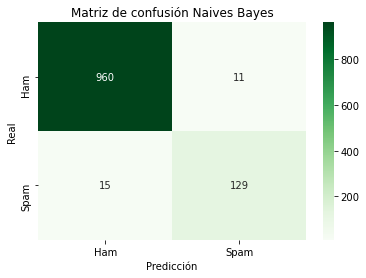

In [51]:
ax = plt.subplot()
sns.heatmap(cf_matrix1, annot=True, ax = ax, cmap='Greens',fmt='')
ax.set_xlabel('Predicción')
ax.set_ylabel('Real')
ax.set_title('Matriz de confusión Naives Bayes')
ax.xaxis.set_ticklabels(['Ham', 'Spam'])
ax.yaxis.set_ticklabels(['Ham', 'Spam'])

### OPCIÓN 2: LSTM - EMBEDDING LAYER (PROBLEMA SUPERVISADO)

In [52]:
# Se obtienen las diferentes métricas del problema (accuracy, precision y recall)
cf_matrix2 =confusion_matrix(test_labels,y_predict_lstm)
tn, fp, fn, tp = confusion_matrix(test_labels, y_predict_lstm).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(test_labels, y_predict_lstm)))
print("Recall: {:.2f}%".format(100 * recall_score(test_labels, y_predict_lstm)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_labels,y_predict_lstm)))

Precision: 96.00%
Recall: 87.59%
F1 Score: 91.60%


[Text(0, 0.5, 'Ham'), Text(0, 1.5, 'Spam')]

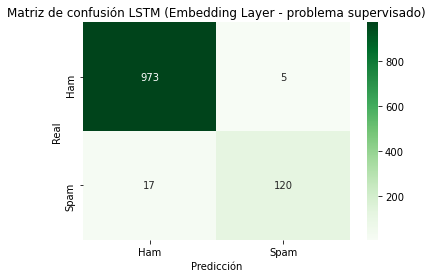

In [53]:
# Matriz de confusión
ax = plt.subplot()
sns.heatmap(cf_matrix2, annot=True, ax = ax, cmap='Greens',fmt='')
ax.set_xlabel('Predicción')
ax.set_ylabel('Real')
ax.set_title('Matriz de confusión LSTM (Embedding Layer - problema supervisado)')
ax.xaxis.set_ticklabels(['Ham', 'Spam'])
ax.yaxis.set_ticklabels(['Ham', 'Spam'])

### OPCIÓN 3: BERT + LSTM

In [54]:
# predict results
preds_bert = np.round(model.predict(X_test)).flatten()

# Se obtienen las diferentes métricas del problema (accuracy, precision y recall)
cf_matrix3 =confusion_matrix(y_test2,preds_bert)
tn, fp, fn, tp = confusion_matrix(y_test2, preds_bert).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(y_test2, preds_bert)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test2, preds_bert)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test2,preds_bert)))

Precision: 98.59%
Recall: 93.96%
F1 Score: 96.22%


[Text(0, 0.5, 'Ham'), Text(0, 1.5, 'Spam')]

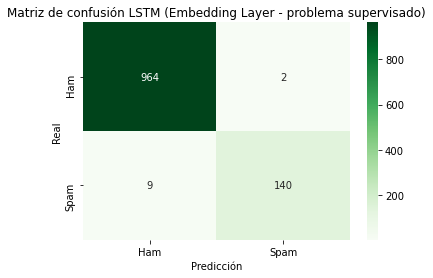

In [55]:
# Matriz de confusión
ax = plt.subplot()
sns.heatmap(cf_matrix3, annot=True, ax = ax, cmap='Greens',fmt='')
ax.set_xlabel('Predicción')
ax.set_ylabel('Real')
ax.set_title('Matriz de confusión LSTM (Embedding Layer - problema supervisado)')
ax.xaxis.set_ticklabels(['Ham', 'Spam'])
ax.yaxis.set_ticklabels(['Ham', 'Spam'])

*Se observa que el modelo con mejor resultado es el tercero, ya que no solo tiene una accuracy muy alta sino también la precisión,el recall y el F1. Además se observa que devuelve muy pocos falsos positivos y negativos. Las redes neuronales devuelven generalmente mejores resultados que los modelos clásicos (en concreto las LSTM funcionan muy bien con este tipo de problemas donde interesa que la red neuronal tenga "memoria" para comprender el contexto de la frase).*

*Además el último modelo trabaja con BERT, que parte de un corpus preentrenado con texto plano (como ocurre con Word2Vec) pero la diferencia con este es que luego se entrena en tu propio texto. BERT (Bidirectional Encoder Representations from Transformers) es una representación de lenguaje bidireccional (es decir que se juzgan las palabras ubicadas a la izquierda y a la derecha de cada uno de los términos). Es un problema no supervisado (es decir, que no requiere un corpus con las respuestas correctas sino que se infieren directamente). Sin embargo, mientras que Word2Vec simplemente genera representaciones para las palabras que aparecen en el vocabulario, BERT tiene en cuenta el contexto.*